In [1]:
import os, sys, json, copy, random, pickle, time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# set to my fork with fix on server
# sys.path.insert(0, '../../../myfastai')
# set to dev-head on local
sys.path.insert(0, '../../../fastaif')
import fastai
print(fastai.__version__)

from fastai.vision import *
from fastai.utils.mem import  gpu_mem_get_free_no_cache

%reload_ext autoreload
%autoreload 2

from modules.ap3data import build_data
from modules.ap3graph import pred_cmp_viz

from modules.miscutils import ( scp_from_gcloud
                               ,move_file_obj
                               ,fastai_version
                              )
from modules.modeleval import ( calc_sse
                               ,calc_mse
                               ,err_to_np
                               ,ModelHome
                               ,Residuals
                              )

1.0.53.dev0


In [3]:
# the two datasets for apfit3-X models / apfit4-X models:
# ap3 used misordered labels, ap4 used correct order

data_misorder = build_data( batch_size=16, 
                            size=(288, 432), 
                            valid_pct=0.2,
                            correct_order=False,
                            )
data_order = build_data(    batch_size=16, 
                            size=(288, 432), 
                            valid_pct=0.2,
                            correct_order=True,
                            )

warning - points are not nec in the right order
all validations pass
all validations pass


In [ ]:
data_misorder.train_dl.y.items)

##### Copied down model artifacts

In [4]:
scp_from_gcloud('new-models/apfit3*', 'new-models/')

running popen and waiting...
new files in dest (new-models/)
apfit3-1.csv
apfit3-1.pth
apfit3-2.csv
apfit3-2.pth
apfit3-2b-smc_0.pth
apfit3-2b-smc_1.pth
apfit3-2b-smc_2.pth
apfit3-2b-smc_3.pth
apfit3-2b-smc_4.pth
apfit3-2b-smc_5.pth
apfit3-2b-smc_6.pth
apfit3-2b-smc_7.pth
apfit3-2b-smc_8.pth
apfit3-2b-smc_9.pth
apfit3-2b.csv
apfit3-2b.pth
apfit3-3.csv
apfit3-4.csv


In [5]:
scp_from_gcloud('new-models/apfit4*', 'new-models/')

running popen and waiting...
new files in dest (new-models/)
apfit4-1.csv
apfit4-1.pth


In [8]:
#copy down preds
scp_from_gcloud('misc-data/*apfit4*', 'misc-data/')

running popen and waiting...
new files in dest (misc-data/)
preds_apfit4-1.pickle


##### Build ModelHome's for each

In [3]:
m1 = ModelHome(
                model_arch=models.resnet50,
                dataset=data_order,
                pth_fn='new-models/apfit4-1.pth',
                name='apfit4-1',
                history_fn='new-models/apfit4-1.csv',
                preds_fn='misc-data/preds_apfit4-1.pickle',
                )

In [4]:
m1

apfit4-1
        valid_err:          tensor(0.0019)
        training_err:       not implemented
        avg predict time:   None
        histroy loaded:     true
        (validation) preds loaded: true
        (training) preds loaded:   not implemented

In [5]:
m2 = ModelHome(
                model_arch=models.resnet50,
                dataset=data_misorder,
                pth_fn='new-models/apfit2-1.pth',
                name='apfit2-1',
                history_fn='new-models/apfit2-1.csv',
                preds_fn='misc-data/preds-apfit2-1.pickle',
                )

In [6]:
m2

apfit2-1
        valid_err:          tensor(0.0103)
        training_err:       not implemented
        avg predict time:   None
        histroy loaded:     true
        (validation) preds loaded: true
        (training) preds loaded:   not implemented

### One Visual Comparison

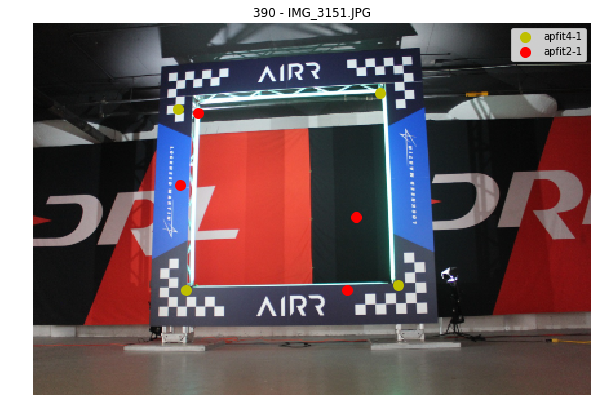

In [59]:
pred_cmp_viz( list_mh = [m1, m2], legend=True, i=390)

### Analysis of Residuals
use helper classes for this

In [9]:
from modules.modeleval import GroundTruth, Predictions, Residuals

In [10]:
# absolute coords
gt1 = GroundTruth([e for e in m1.dataset.valid_dl.y.items])

# flow coords
gt2 = GroundTruth(m1.preds[1])

In [54]:
def display_bookends(datalist, metricname='metricname' ):
    ''' print and display largest + smallest elements
        based on metric passed in.'''
    
    metric_large = max(enumerate(datalist),key=lambda x: x[1])
    img_large = m1.dataset.valid_dl.x.get(metric_large[0])
    
    print('largest ', metricname, metric_large)
    img_large.show(figsize=(4,4), title='largest ' + metricname)
    
    metric_small = min(enumerate(datalist),key=lambda x: x[1])
    img_small = m1.dataset.valid_dl.x.get(metric_small[0])
    
    print('smallest ', metricname, metric_small)
    img_small.show(figsize=(4,4), title='smallest ' + metricname)
    

##### build areas data list

1165
[0.05670224130153656, 0.11381619423627853, 0.1110825166106224]
largest  areas (831, 1.6540921926498413)
smallest  areas (667, 0.009580765850841999)


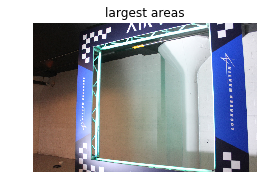

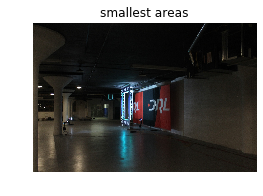

In [62]:
areas = gt2.get_interior_size()
print(len(areas))
print(areas[:3])

display_bookends(areas, 'areas')

##### build perspective_ratio datalist

1165
[0.9324325323104858, 0.9944441914558411, 0.9267016053199768]
largest  perspective ratio (72, 1.0)
smallest  perspective ratio (456, 0.7264573574066162)


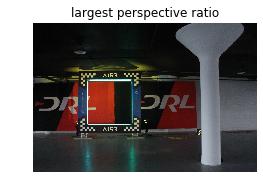

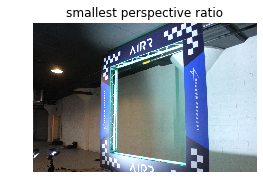

In [61]:
pratios = gt2.get_perspective_ratio()
print(len(pratios))
print(pratios[:3])

display_bookends(pratios, 'perspective ratio')

1165
[0.5362319350242615, 0.6629422903060913, 0.6440678238868713]
largest  perspective2 ratio (349, 0.7632653713226318)
smallest  perspective2 ratio (907, 0.08695650845766068)


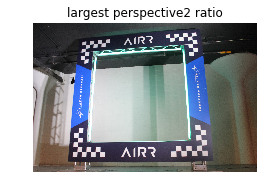

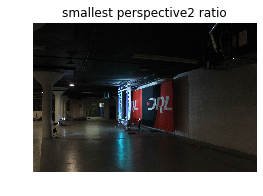

In [63]:
pratios = gt2.get_perspective_ratio(b_mix=True)
print(len(pratios))
print(pratios[:3])

display_bookends(pratios, 'perspective2 ratio')

##### Compare Residuals on different factors

In [35]:
res = Residuals(m2.preds[2])

In [36]:
losses = res.get_loss()

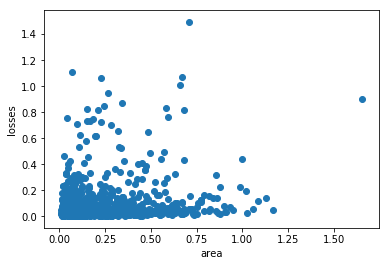

In [37]:
plt.scatter(areas, losses,)
_ = plt.xlabel('area')
_ = plt.ylabel('losses')

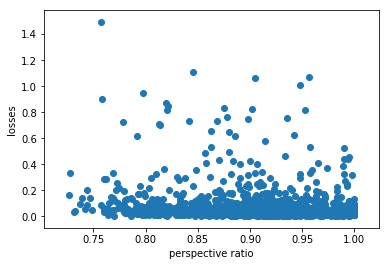

In [41]:
plt.scatter(pratios, losses,)
_ = plt.xlabel('perspective ratio')
_ = plt.ylabel('losses')

##### Use pred_cmp_viz
as can be seen, the correctly ordered labels model (apfit4) far outperfroms the msiordered labels (apfit3)

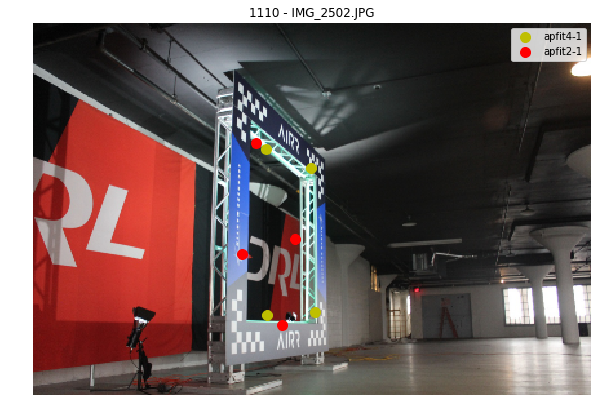

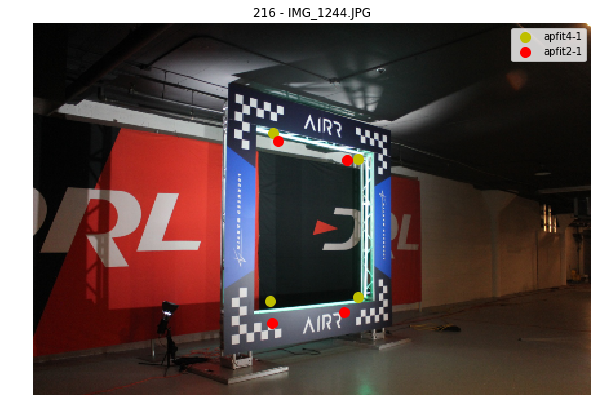

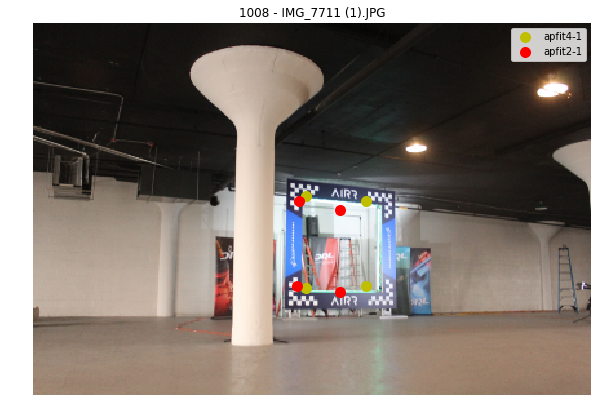

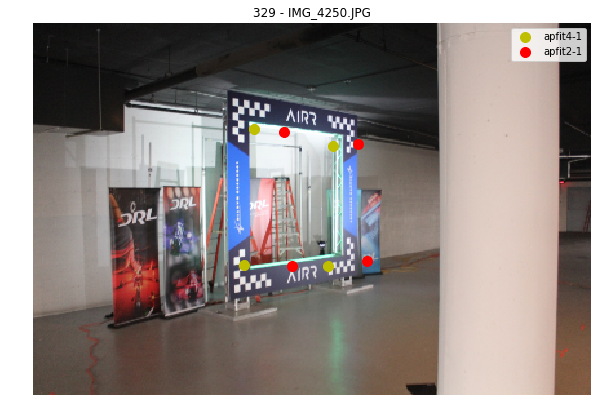

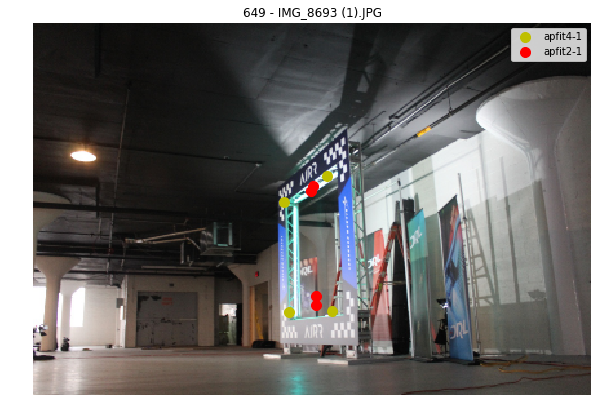

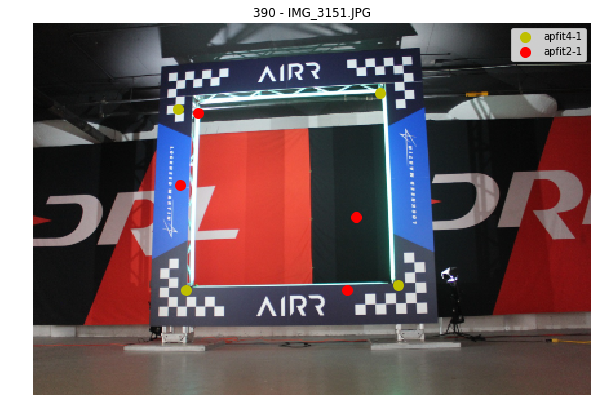

In [55]:
for _ in range(6):
    
    pred_cmp_viz( list_mh = [m1, m2]
                 ,add_truth = False
                 ,legend=True
                 ,b_train=False
                 ,i=None
                )